# Advances in Machine Learning with Big Data

### Trinity 2021
### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [15, 3]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

import itertools      # today, we'll use this

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

## 5. Resampling methods, and model selection

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. **Resampling methods, and model selection**

1. Classification

1. Decision trees, bagging, and random forests

1. Make a start on neural networks

Load data per previous classes ...

In [3]:
df = uci_files.standard_uci_data_access()

2020-05-10 14:29:52,305 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-05-10 14:29:55,474 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [4]:
invalids = stock_codes.invalid_series(df)

In [5]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

In [6]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

### We will tune [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) on this data.

#### First, rebuild class 4:

In [7]:
N_FOLDS = 25

y = invoices.log_item_spend
X = invoices[predictors] 

# Prepare for polynomial regression:
poly = PolynomialFeatures(4, include_bias=False)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)

poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

I hard-coded my guesses at good parameters values for `alpha` and `l1_ratio`:

In [8]:
elastic = linear_model.ElasticNet( # << Elastic Net here
                                  alpha=25 / (len(y) / N_FOLDS) / 2,   # alpha parameter
                                  l1_ratio=0.33                        # how to distribute the parameter between l1 and l2 norms
                                 )

Do the hard work:

In [9]:
scores = sbs_sklearn.train_n_test(poly_std_X, y, N_FOLDS, train_on_minority=True, model=elastic)

2020-05-10 14:30:08,093 INFO:Study 1/25: 824 train rows;  19753 test rows


Plot the results

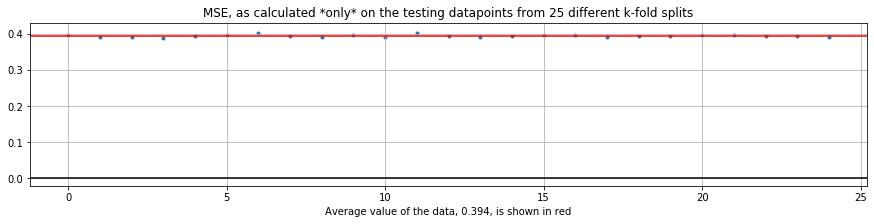

In [10]:
sbs_sklearn.plot_kfold_scores(scores, scatter=True)

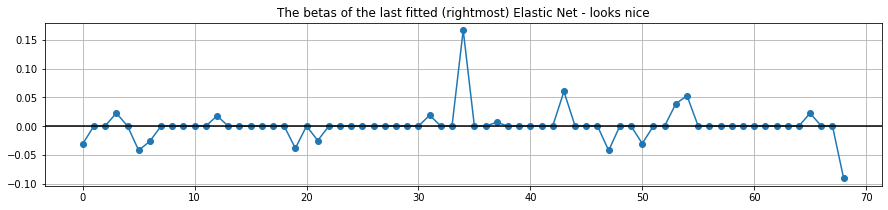

In [11]:
plot_coeffs(elastic, 'last fitted (rightmost) Elastic Net', 'looks nice')

### The issue here:

Even tuning parameters / 'hyperparameters' like $\alpha$ can suffer from overfit: I probably overfitted them!

How can we save effort & self-doubt, and be more systematic?

Reminder of how I set the regularizing parameters:

In [12]:
elastic.alpha * (len(y) / N_FOLDS) * 2

25.0

In [13]:
elastic.l1_ratio

0.33

### **Cross-Validation**

Systematically *tune* the fitting technique('s parameters)

The most-advocated strategy here uses **k-fold test/train splits**

#### purposes:

* Estimating out-of-sample quality (hence degradation) in fit ...
* ... and thereby, model selection

#### references:

* *Introduction to Statistical Learning* Ch. 5
* *Elements of Statistical Learning* Ch. 7
* [Wikipedia's take](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
* [scikit-learn's account](https://scikit-learn.org/stable/modules/cross_validation.html)

### Basic idea: to break the dataset up into parts

We add a further stratum to our dataset:
* until now, we had just 2 parts: `train -> test`
* from now onwards, 3 parts: `train -> validation -> test`

Yes, this switch in terminology can be [confusing](https://en.wikipedia.org/w/index.php?title=Training,_validation,_and_test_sets&section=5#Confusion_in_terminology), [and (personally) sometimes puzzling](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In **cross**-validation, we perform the `train/validation` split in multiple ways and collate the results.

The `test` set is constant; and held-out as a final 'acid' test of the whole approach.

### Forms of cross-validation

* Exhaustive (computationally intensive)
   * Leave-$p$-out
       * Perform $N$-choose-$p$ splits/partitions of the non-test data. 
          * **training** sets are the parts of size $(N-p)$
          * **validation** sets are 'batches' size $p$
   * Leave-one-out (LOOCV; $p=1$)
   * ...

* Non-Exhaustive (inherently random)
    * K-Fold CV - https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation
    * ...

Which form of cross-validation is best?

In [14]:
def esl_seven_eight():
    N = np.arange(20000)
    plt.plot(N, 1 - 0.9 * (np.tanh(np.sqrt(N/2000))))
    plt.grid(); plt.xlabel('training data size, $N$'); plt.ylabel('expected test error')
    plt.title("ESL Figure 7.8 - hypothetical learning curve for a classifier on a given task")

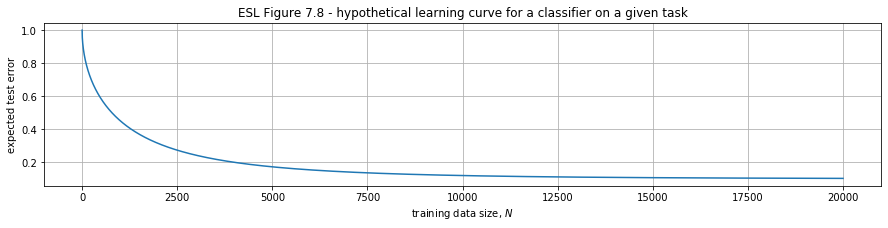

In [15]:
esl_seven_eight()

There's a lower bound on this diagram >0, because the classifier has
1. pointwise **bias** (it cannot flex to accommodate the truth), 
2. dataset-driven **variance**, and 
3. irreducible **residual error**.

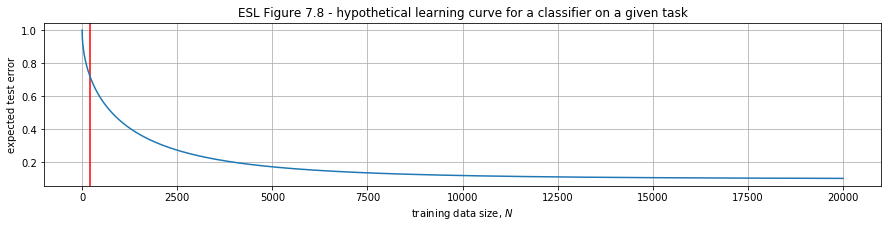

In [16]:
plt.axvline(200, color='r'); esl_seven_eight()

How would we set $p$ in a leave-$p$-out study?:
* if $N$ were 200, and we set $p$ >> 1, we would probably over-estimate prediction error
   * This might lead us to prefer an overly-rigid tuning

* if $N$ were 20,000, presumably we would set $p >> 1$
   * Imagine we set $p=1$. But each fold would get a clearer score, if we switched one or more data, from training to validation.
   * With $p >> 1$, at little cost, we average across many different scenarios, reducing over-all variance.
   * [Mark van der Laan thoughts on this](https://vanderlaan-lab.org/2017/11/22/leave-p-out-cross-validation/)

In practice, setting $p>>1$ for large $N$ is computationally prohibative because $N$-choose-$p$ is big

This suggests non-exhaustive cross-validation.
* It's likely that we only have to draw a few of the $N$-choose-$p$ splits in order to get most of the benefit.
* Ideally, they shouldn't overlap too much.
    * hang on ... test sets needn't overlap at all ...

Two seminal papers are mentioned in *ESL* here; both lead to a similar recommendation / rule-of-thumb:

* K-fold cross-validation with $K=5$ or $K=10$.

* Observations are picked for `train` successively and **without replacement**.

> [Breiman and Spector (1992)](https://www.jstor.org/stable/1403680?seq=1)

> [Kohavi (1995)](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.48.529)

K-fold is **not** principally motivated by ease-of-computation, but of course it helps.

https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

### Practical study

Prepare validation and test data:

In [17]:
from sklearn.model_selection import train_test_split

We will put `poly_std_X_test` and `y_test` to one side until the end of our work:

In [18]:
(poly_std_X_tr_val, 
 poly_std_X_test,
 y_tr_val, 
 y_test) = train_test_split(poly_std_X, y, test_size=0.1)  # < proportion 0.1 of the data put aside for final testing

However, we will successively break `poly_std_X_tr_val` and `y_tr_val` using KFolds splits into:
* training data
* validation data

First we'll see what this means, using our existing code.

Lets program a simple grid search:

In [19]:
alphas = [0.1, 1, 10, 100, 1000]    # going up in factors of ten
l1_ratios =  [0.1, 0.5, 0.9]          # one balanced split, and two unbalanced splits (each way)
k_folds = [5, 10]

In [20]:
score_cube = np.empty((len(alphas), len(l1_ratios), len(k_folds)))

In [21]:
score_cube.shape

(5, 3, 2)

In [22]:
score_cube[:] = np.nan   # a numpy operation: set all its elements to nan

for i, a in enumerate(alphas):
    for j, l in enumerate(l1_ratios):
        for k, f in enumerate(k_folds):
            
            elastic_for_grid = linear_model.ElasticNet(alpha=a / len(y_tr_val) / 2, l1_ratio=l)
            scores = sbs_sklearn.train_n_test(poly_std_X_tr_val, y_tr_val, f, train_on_minority=True, model=elastic_for_grid)
            score_cube[i, j, k] = np.mean(scores)

2020-05-10 14:30:10,817 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:11,753 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:12,660 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:13,573 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:14,436 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:15,388 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:16,271 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:17,235 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:18,131 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:19,167 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:20,295 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:21,613 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:30:22,654 INFO:Study 1/5: 3704 train rows;  14815 test rows
2020-05-10 14:30:23,764 INFO:Stu

That took a while, lets look at the results:

In [23]:
score_bps = (score_cube * 1e4).astype(int)

In [24]:
for k, f in enumerate(k_folds):
    print(f"\n{f}-fold splits, each with {len(y_tr_val)//f} training data:")
    print(" " + "  ".join(str(l) for l in l1_ratios), "  : L1 - ratios")
    for i, a in enumerate(alphas):
        print(score_bps[i, :, k], ": alpha =", a)


5-fold splits, each with 3703 training data:
 0.1  0.5  0.9   : L1 - ratios
[3859 3886 3878] : alpha = 0.1
[3871 3867 3872] : alpha = 1
[3869 3875 3866] : alpha = 10
[3871 3887 3877] : alpha = 100
[3879 3923 3956] : alpha = 1000

10-fold splits, each with 1851 training data:
 0.1  0.5  0.9   : L1 - ratios
[3904 3918 3905] : alpha = 0.1
[3900 3917 3917] : alpha = 1
[3906 3901 3883] : alpha = 10
[3887 3899 3890] : alpha = 100
[3892 3927 3961] : alpha = 1000


... clunky to code, so lets let Scikit-learn take the strain:

### Applying Elastic Net Cross-Validation within Scikit-Learn

In [25]:
elasticCV = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .75, .95])
n_folds = 10

2020-05-10 14:30:38,174 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:31:13,796 INFO:Study 10/10: 1851 train rows;  16668 test rows


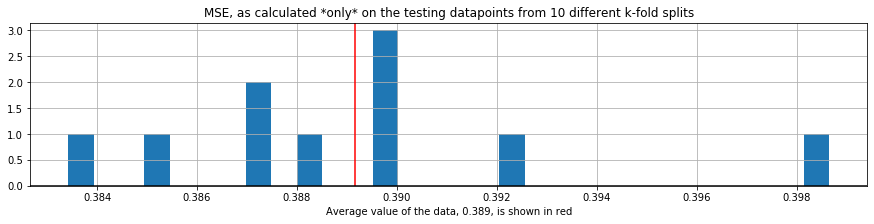

In [26]:
scores = sbs_sklearn.train_n_test(poly_std_X_tr_val, y_tr_val, n_folds, 
                                  train_on_minority=True, model=elasticCV, update_frequency=9)
sbs_sklearn.plot_kfold_scores(scores)

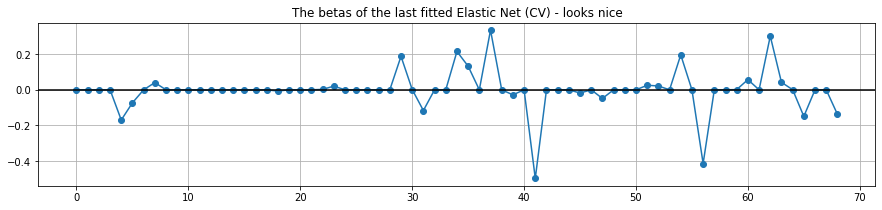

In [27]:
plot_coeffs(elasticCV, 'last fitted Elastic Net (CV)', 'looks nice')

In [28]:
f"Cross Validation tunes alpha parameter to {elasticCV.alpha_ * (len(y_tr_val) / n_folds) * 2 :.2f}, whereas JL had found 25 by guessing"

'Cross Validation tunes alpha parameter to 1.99, whereas JL had found 25 by guessing'

Let's do a LassoCV while we're about it:

2020-05-10 14:31:18,467 INFO:Study 1/10: 1852 train rows;  16667 test rows
2020-05-10 14:31:26,464 INFO:Study 10/10: 1851 train rows;  16668 test rows


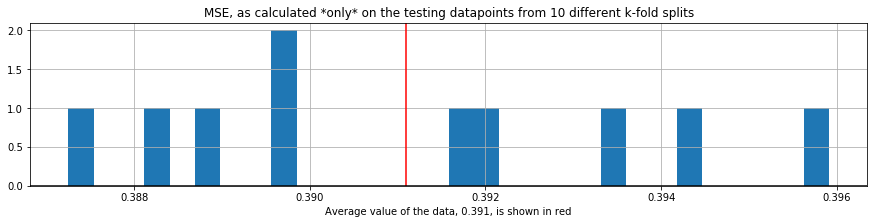

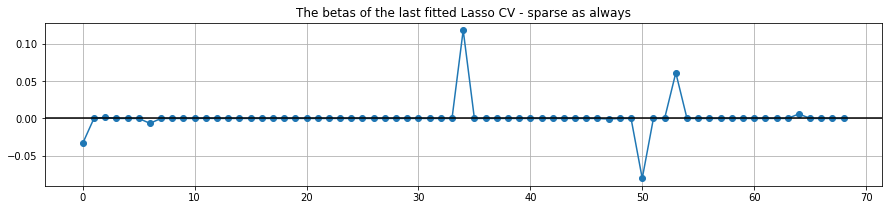

In [29]:
lassoCV = linear_model.LassoCV()
scores = sbs_sklearn.train_n_test(poly_std_X_tr_val, y_tr_val, n_folds, 
                                  train_on_minority=True, model=lassoCV, update_frequency=9)
sbs_sklearn.plot_kfold_scores(scores)
plot_coeffs(lassoCV, 'last fitted Lasso CV', 'sparse as always')

In [30]:
f"Cross Validation tunes alpha parameter to {lassoCV.alpha_ * (len(y_tr_val) / n_folds) * 2 :.2f}, whereas JL had found 25 by guessing"

'Cross Validation tunes alpha parameter to 29.45, whereas JL had found 25 by guessing'

**Exercise**: This is an exercise about building, and then handling, categorical predictors. 

In a new copy of this notebook we will rewrite the part early-on where $X$ is defined.

* research, and then create, an `sklearn.preprocessing.OneHotEncoder()`

* in analogy to `polynomial_X`, create a `one_hot_X` which encodes *hour*, *month*, and *country*, giving it suitable column names. hint: see [example code here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

* how many additional columns does `one_hot_X` have?

* add these columns to `poly_std_X` and run the notebook through.

* can these cross-validation techiques handle so many, related, features? Do results improve, hold steady, or degrade?

### The Bootstrap

*Introduction to Statistical Learning* 5.2

[Wikipedia](   https://en.wikipedia.org/wiki/Bootstrapping_(statistics)   ) 

**A general model-building technique** to add to our toolkit. 

(as ever, it degrades when, having applied it to `train` data, we then try `validation`, then `test`.)

### The Bootstrap: the problem setup

I am working with my `training` sample, $z$. It consists of $N$ observations that I can say are somewhat iid. I've developed an estimator, $S(Z)$, and the related estimate, $S(z)$.

  * so, $S(Z)$ is a random variable I've defined in order to measure a parameter of interest in the DGP, $\theta$
  
  * hopefully, its consistent, unbiased, even statistically efficient, 
  
  * however, whether or not it has these properties:

If I want to do inference, I will need to *estimate* its CDF, $F_S$, and/or its moments.

To get at $F_S$, the main approach from Michaelmas Term: asymptotic Central Limit Theory, e.g.
  
\begin{equation}
\sqrt{N}\left(S(Z) - \theta\right) \rightarrow^D \mathcal{N}(0, \sigma^2)
\end{equation}

as $N \rightarrow \infty$. 

Now, however, we seek an alternative which exploits 
* improved computing power, and 
* larger sets of data.

### The Bootstrap is known for its **principle** and its **method**

Bootstrap principle:

1. Replace the population distribution of the samples, with their empirical distribution (per our dataset)

2. Derive $\tilde F_S$, by which we'll mean:
    * the CDF of $S$, 
    * under the distributional assumption in 1.

3. Consider this to be a good *estimator* of $F_S$

Bootstrap method:

1. Where $i$ runs up through the integers from 0 to a big number:

     1. Randomly pick, *with replacement*, $N$ elements from $z$, assembling these to get $\tilde z_i$.

     1. Calculate and store $S(\tilde z_i)$

1. Study (plot) quantiles/distribution of the large set $\{S(\tilde z_1), S(\tilde z_2), S(\tilde z_3), ... \}$

1. Observe that this distribution approximates $\tilde F_S$

1. Consider this to be a good *estimator* of $F_S$.

**Exercise**: Figure out what proportion of the dataset is included in a typical bootstrap sample. 

Hint: Consider the limit as $N\rightarrow\infty$ of $\left(1-\frac1N\right)^N$.

### We code up the bootstrap and try it out

(using `numpy`, including `numpy.random` - not many lines of code)

In [31]:
def bootstrap_resample(S):
    """
    @param S: a function that takes data and gives a statistic we want to know about
    @return: a new function that takes such data, and adds a smidge of randomness to get the bootstrap statistic
    """
    def func(Z):
        """
        @param Z: a numpy.array of data where the first dimension indexes the observations
        """
        Z_resampled = Z[np.random.randint(0, high=len(Z), size=len(Z))]
        return S(Z_resampled)
    return func

In [32]:
def show(statistic):
    return pd.DataFrame(statistic).round(1)

Think of a statistic, any statistic ...

In [33]:
def my_cov(z):
    """
    @return empirical covariance matrix
    """
    return np.dot(z.T, z) / len(z)

Let's pull out a `training` chunk of our familiar $X$:

In [34]:
n_train = 10000  # imagine we're keeping the first 10000 observations for training
x = X.values[:n_train]

In [35]:
X.columns

Index(['log_n_codes', 'hour', 'month', 'words_per_item'], dtype='object')

We'll view the empirical covariance matrix of `x`:

In [36]:
show(my_cov(x))

,0,1,2,3
0,7.9,32.3,5.098321e+05,7.3
1,32.3,165.7,2.542678e+06,39.5
2,509832.1,2542678.4,4.039634e+10,629197.6
3,7.3,39.5,6.291976e+05,10.5


... but how does this deviate from the true covariance matrix of $x_i$ (for any $i$)?

We begin by looking at an example of the bootstrap-resampled statistic:

In [37]:
br = bootstrap_resample(my_cov)(x)

In [38]:
show(br)

,0,1,2,3
0,8.0,32.3,5.120536e+05,7.3
1,32.3,164.9,2.535843e+06,39.3
2,512053.6,2535842.6,4.039628e+10,627323.8
3,7.3,39.3,6.273238e+05,10.4


... not that different to `my_cov(x)`

... but now lets make a `list` of many (well, 1000) of these, each of them different because each is based on a different random sample of $X$:

In [46]:
# ... using python's list comprehension:
bootstraps = [bootstrap_resample(my_cov)(x) for i in range(0, 1000)]
print(f"Did {len(bootstraps)} bootstraps, each gives a matrix of shape {bootstraps[0].shape}.")

Did 1000 bootstraps, each gives a matrix of shape (4, 4)


These have a highly suitable mean - we can think of this like a *consensus* of multiple estimators(/models) of that covariance:

In [41]:
show(np.mean(bootstraps, axis=0))

,0,1,2,3
0,7.9,32.3,5.098385e+05,7.3
1,32.3,165.7,2.542741e+06,39.5
2,509838.5,2542741.0,4.039634e+10,629231.8
3,7.3,39.5,6.292318e+05,10.5


Our theory tells us that: 

 * the standard deviations of the elements of `bootstraps` ...
 * ... is an estimate ...
 * ... of the standard deviation of the sample covariance matrix, itself.

OK, then lets take a look at these standard deviations:

In [42]:
show(np.std(bootstraps, axis=0))

,0,1,2,3
0,0.1,0.2,2537.5,0.0
1,0.2,0.6,4789.8,0.1
2,2537.5,4789.8,137014.4,1686.3
3,0.0,0.1,1686.3,0.1


**Exercise**: recall, the bootstrap is a model like any other, and could/should be tested

* Locate the test data we defined for this exercise of bootstrapping the stdev of $X$'s cov matrix.

* Implement this bootstrap on the test data.

* Comment on how effectively the bootstrap on the training data has generalized to new cases.

* In the light of this, what principles can we think of, that we might apply to improve our bootstrap technique?